# WaveNet
In the [Pixel CNN](https://arxiv.org/pdf/1606.05328.pdf) paper, van den Oord et al. showed that it was possible to generate images autoregressively with a convolutional neural network, 1 pixel at a time. Naturally, these authors asked if this was possible for audio as well. The resulting model is [WaveNet](https://arxiv.org/pdf/1609.03499.pdf), a deep convolutional neural network that conditions on a sequence of digital audio samples, and predicts the next sample in the sequence. The final prediction is a standard discrete softmax, made possible by quantizing the audio samples.

The main challenge with this approach is that the sequence dependencies are extremely long. For instance, low quality telephone audio typically has 8000 audio samples every second. WaveNet overcomes this challenge by using stacked dilated convolutions to produce a very large receptive field.

The network consists of a stack of residual blocks. Each residual block starts with a dilated 1D convolution. Then, two separate 1x1 convolutions are performed and passed through a tanh and a sigmoid, respectively. These are recombined by multiplying, forming a gated activation unit. Finally, two 1x1 convolutions produce the output and a skip connection. All of the skip connections in the network are summed and passed through two 1x1 convolutions with ReLU to produce the final softmax prediction. The network is then trained with [Adam](https://arxiv.org/pdf/1412.6980.pdf) on the standard cross entropy loss

## Overview

We will begin by examining the MAESTRO dataset, consisting of solo piano performances. We will then implement an unconditional WaveNet model and perform limited training. Finally, we will examine samples produced by the network.

## A small experiment

The [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro) consists of raw audio and recorded MIDI from the [International Piano-e-Competition](http://piano-e-competition.com/). We will use version 1 of the dataset, available as a 86GB zip file [here](https://storage.googleapis.com/magentadata/datasets/maestro/v1.0.0/maestro-v1.0.0.zip).

Since we have limited resources to train, we will use [SoX](http://sox.sourceforge.net/) to downsample all of the audio to 4000 samples a second. Although this will result in a significant loss in quality, the characteristic sound of the piano is not lost. To match this notebook, the prepared data should consist of the downsampled WAV files from the 2008 competition year in a directory called ```data``` placed in the same directory as this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchaudio
from IPython.display import Audio
from IPython.display import display
import os

For quantization, we will use the [$\mu$-law algorithm](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm) with 64 discrete values. Similar to before, this heavy quantization was selected since we have limited resources to train.

In [2]:
def quantize(x, mu=63):
    fx = torch.sign(x)*torch.log(1 + mu*x.abs())/np.log(1 + mu)
    return torch.floor(((fx + 1) / 2)*mu + 0.5).long()

def continuous(x, mu=63):
    contx = 2*(x.float()/mu) - 1
    return torch.sign(contx)*(1/mu)*((1+mu)**torch.abs(contx) - 1)

Let's listen to an audio clip from the dataset, and how all of the required transformations affect its sound. Note that this audio is stereo. We will use just the right channel to train the network on mono audio.

In [3]:
print('Original Audio')
waveform, sample_rate = torchaudio.load('./data/MIDI-Unprocessed_17_R2_2008_01-04_ORIG_MID--AUDIO_17_R2_2008_wav--3_original.wav')
display(Audio(waveform[:, :5*sample_rate].numpy(), rate=sample_rate))

print('Quantized Audio')
waveform, sample_rate = torchaudio.load('./data/MIDI-Unprocessed_17_R2_2008_01-04_ORIG_MID--AUDIO_17_R2_2008_wav--3_original.wav')
display(Audio(continuous(quantize(waveform[:, :5*sample_rate])).numpy(), rate=sample_rate))

print('Downsampled Audio')
waveform, sample_rate = torchaudio.load('./data/MIDI-Unprocessed_17_R2_2008_01-04_ORIG_MID--AUDIO_17_R2_2008_wav--3.wav')
display(Audio(waveform[:, :5*sample_rate].numpy(), rate=sample_rate))

print('Downsampled and Quantized Audio')
waveform, sample_rate = torchaudio.load('./data/MIDI-Unprocessed_17_R2_2008_01-04_ORIG_MID--AUDIO_17_R2_2008_wav--3.wav')
display(Audio(continuous(quantize(waveform[:, :5*sample_rate])).numpy(), rate=sample_rate))

Original Audio


Quantized Audio


Downsampled Audio


Downsampled and Quantized Audio


Now we will prepare the dataset object. This will consist of converting an index into a slice into a particular WAV file. We will return blocks of 15000 samples from the right audio channel. Since the quantization is heavy, we will also quantize the input audio so that it more closely matches the conditions seen during the autoregressive generation after training. This step may not be necessary.

In [6]:
class MusicDataset(Dataset):
    def __init__(self, folder, sample_size=15000, transform=None):
        self.folder = folder
        self.sample_size = sample_size
        self.transform = transform
        
        self.files = [f for f in os.listdir(folder) if f.endswith('.wav')]
        self.lengths = [0]*len(self.files)
        for t, f in enumerate(self.files):
            p = os.path.join(self.folder, f)
            waveform, _ = torchaudio.load(p)
            assert waveform.size(1) - 1 >= sample_size, "sample_size is too large"
            self.lengths[t] = waveform.size(1) - sample_size - 1
        self.c_lengths = np.concatenate([[0], np.cumsum(self.lengths)[0:-1]])
        
    def __len__(self):
        return self.c_lengths[-1]+self.lengths[-1]
        
    def __getitem__(self, idx):
        f_index = (self.c_lengths <= idx).nonzero()[0][-1]
        index = idx - self.c_lengths[f_index]
        
        p = os.path.join(self.folder, self.files[f_index])
        waveform, _ = torchaudio.load(p)
        sample = (waveform[-1:, index:index+self.sample_size], \
                  waveform[-1:, index+1:index+1+self.sample_size])
        
        assert sample[0].size(1) == self.sample_size and \
               sample[1].size(1) == self.sample_size, "issue with index " + str(idx)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
class Quantize(object):
    def __call__(self, sample):
        x, y = sample
        sample = (continuous(quantize(x)), \
                  torch.squeeze(quantize(y)))
        return sample

In [7]:
sample_rate = 4000
dataset = MusicDataset('./data/', transform=Quantize())
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=6)

Let's listen to a sample from the dataset.

In [8]:
display(Audio((dataset[np.random.randint(len(dataset))][0]).numpy(), rate=sample_rate))

Now we will create an implementation of WaveNet. The convolutions in the network need to respect causality, i.e. that a sample at time $t$ can only be predicted from samples at times less than $t$. This was implemented by adding padding to the front of sequences, as suggested [here](https://github.com/pytorch/pytorch/issues/1333).

To improve performance during generation, one can have a buffer that stores the previous results of a pass of the network, and only compute the very last sample. This feature can be enabled via ```fast_generate``` and was originally proposed [here](https://arxiv.org/pdf/1611.09482.pdf). 

Most parameters were not mentioned in the original paper, but good baseline parameters can be found [here](https://github.com/ibab/tensorflow-wavenet). 

In [12]:
class ResBlock(nn.Module):
    def __init__(self, dilation, \
                 filter_size=2, channels=32, \
                 skip_channels=256):
        super().__init__()
        self.dilation = dilation
        self.filter_size = filter_size
        
        self.input_conv = nn.Conv1d(channels, channels, filter_size, dilation=dilation)
        self.gate_conv = nn.Conv1d(channels, channels, 1)
        self.val_conv = nn.Conv1d(channels, channels, 1)
        self.out_conv = nn.Conv1d(channels, channels, 1)
        self.skip_conv = nn.Conv1d(channels, skip_channels, 1)
        
    def forward(self, tup_in):
        x, skip_in, fast_generate = tup_in
        
        # Save input for residual connection
        x_in = x
        
        # If fast_generate, then only do computation with last sample
        if fast_generate:
            x = x_in[:,:,-(self.filter_size + (self.filter_size-1)*(self.dilation-1)):]
            x = self.input_conv(x)
            
        # Pad to perform casual dilated convolution
        else:
            pad_n = self.dilation * (self.filter_size - 1)               
            x = self.input_conv(F.pad(x, (pad_n, 0)))
        
        # Compute tanh(Wx)*sigmoid(Wx)
        gate = torch.sigmoid(self.gate_conv(x))
        val = torch.tanh(self.val_conv(x))
        x = val*gate
        
        # Compute output and skip connection
        if fast_generate:
            try:
                out = torch.cat((self.out_buffer[:,:,1:],self.out_conv(x) + x_in[:,:,-1:]), dim=2)
                skip = torch.cat((self.skip_buffer[:,:,1:],self.skip_conv(x) + skip_in[:,:,-1:]), dim=2)
            except:
                raise RuntimeError("You must do a normal pass of the network first to fill the buffers" \
                                   " before using fast generate.")
        else:
            out = x_in + self.out_conv(x)
            skip = skip_in + self.skip_conv(x)

        # Buffer for fast generation
        self.out_buffer = out.detach()
        self.skip_buffer = skip.detach()
        
        return (out, skip, fast_generate)
        

class WaveNet(nn.Module):
    def __init__(self, device, n_layers=5, dilation_seq=[1,2,4,8,16,32,64,128,256,512], \
                 input_filter=32, filter_size=2, channels=32, skip_channels=256, quantized=64):
        super().__init__()
        self.device = device
        self.input_filter = input_filter
        self.skip_channels = skip_channels
        self.input_conv = nn.Conv1d(1, channels, input_filter)
        
        seq = []
        for l in range(n_layers):
            for d in dilation_seq:
                seq.append(ResBlock(d, filter_size=filter_size, channels=channels, skip_channels=skip_channels))
        self.model = nn.Sequential(*seq)
        
        self.out_conv1 = nn.Conv1d(skip_channels, skip_channels, 1)
        self.out_conv2 = nn.Conv1d(skip_channels, quantized, 1)
        
    def forward(self, x, fast_generate=False):
        if fast_generate:
            try:
                x = x[:,:,-self.input_filter:]
                x = self.input_conv(x)
                x = torch.cat((self.in_buffer[:,:,1:], x), dim=2)
            except:
                raise RuntimeError("You must do a normal pass of the network first to fill the buffers" \
                                   " before using fast generate.")
        else:
            pad_n = 1 * (self.input_filter - 1)
            x = self.input_conv(F.pad(x, (pad_n, 0)))
        
        self.in_buffer = x.detach()
        
        skip = torch.zeros(x.size(0), self.skip_channels, 1, device=self.device)
        _, x, _ = self.model((x, skip, fast_generate))

        if fast_generate:
            try:
                x = x[:,:,-1:]
                x = self.out_conv1(torch.relu(x))
                x = self.out_conv2(torch.relu(x))
                x = torch.cat((self.out_buffer[:,:,1:], x), dim=2)
            except:
                raise RuntimeError("You must do a normal pass of the network first to fill the buffers" \
                                   " before using fast generate.")
        else:
            x = self.out_conv1(torch.relu(x))
            x = self.out_conv2(torch.relu(x))

        self.out_buffer = x.detach()
        return x

Let's test the use of ```fast_generate```.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = WaveNet(device)
net.to(device)

x = torch.randn(1,1,10001).to(device)
a = net(x[:,:,:-1], fast_generate=False)
b = net(x[:,:,1:], fast_generate=True)
c = net(x[:,:,:], fast_generate=False)
print(torch.allclose(b[0,0,:],c[0,0,1:], rtol=1e-3))

True


Now we are ready to train! We will use a linear learning rate warmup to try and improve performance.

The network has 768096 parameters.
Iteration 0 : Loss 4.188541
Iteration 100 : Loss 4.189789
Iteration 200 : Loss 3.5429146
Iteration 300 : Loss 3.5009315
Iteration 400 : Loss 3.7873333
Iteration 500 : Loss 3.2734318
Iteration 600 : Loss 3.5159476
Iteration 700 : Loss 3.4326851
Iteration 800 : Loss 2.9997258
Iteration 900 : Loss 2.1847358
Iteration 1000 : Loss 2.343754
Iteration 1100 : Loss 2.3311381
Iteration 1200 : Loss 1.9057908
Iteration 1300 : Loss 2.7797318
Iteration 1400 : Loss 2.2395413
Iteration 1500 : Loss 2.1988745
Iteration 1600 : Loss 2.701524
Iteration 1700 : Loss 2.5724635
Iteration 1800 : Loss 2.9122112
Iteration 1900 : Loss 2.6840396
Iteration 2000 : Loss 1.7807541
Iteration 2100 : Loss 2.484378
Iteration 2200 : Loss 3.276641
Iteration 2300 : Loss 2.0369563
Iteration 2400 : Loss 2.0394003
Iteration 2500 : Loss 2.8341448
Iteration 2600 : Loss 1.6376774
Iteration 2700 : Loss 2.7805777
Iteration 2800 : Loss 1.9451286
Iteration 2900 : Loss 2.4950519
Iteration 3000 : Loss 2

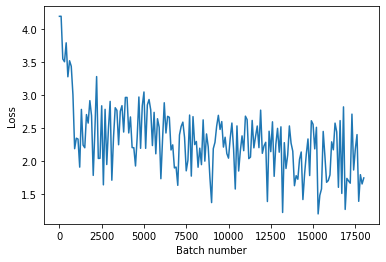

In [34]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = WaveNet(device)
net.to(device)

### Taken from the PyTorch forums
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
###
print('The network has ' + str(num_params) + ' parameters.')

optim = torch.optim.Adam(net.parameters(), lr=0.002)
loss_f = torch.nn.CrossEntropyLoss()
n_epochs = 1
losses = []
iterations = []
batch_num = 0

train = True # Whether or not we should train the network, or just load it

# Train the network
if train:
    for epoch in range(1,n_epochs+1):
        for i_batch, sampled_batch in enumerate(dataloader):
            # Linear learning rate warmup
            lr = 0.002 * min(1, (i_batch+1)/4000)
            for param_group in optim.param_groups:
                param_group['lr'] = lr
            
            x = sampled_batch[0].to(device)
            y = sampled_batch[1].to(device)
            pred = net(x)

            loss = loss_f(pred, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # Log
            if batch_num % 100 == 0:
                with torch.no_grad():
                    loss = loss.cpu().numpy()
                    losses.append(loss)
                    iterations.append(batch_num)
                    print('Iteration ' + str(batch_num) + ' : Loss ' + str(loss))
            batch_num += 1
            
            if i_batch == 18000:
                break
            
    torch.save(net.state_dict(), 'net.pt')

    plt.plot(iterations, losses)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    
# Load the network
else:
    net.load_state_dict(torch.load('net.pt'))

Let's produce some samples from the network seeded from audio at arbitrarily selected indices in the dataset. The temperature parameter was manually tuned.

In [35]:
def generate(index, length, temperature=0.01):
    x = dataset[index][0].unsqueeze(0).to(device)
    
    print("Audio prompt")
    display(Audio(x[0].cpu().numpy(), rate=sample_rate))
    
    fast_generate = False # Needs to be false for first iteration of loop

    for t in range(length*sample_rate):
        with torch.no_grad():
            logits = net(x[:,:,-10000:], fast_generate=fast_generate)[0,:,-1]
        dist = torch.distributions.categorical.Categorical(logits=logits/temperature)
        nx = continuous(dist.sample())
        x = torch.cat((x, nx*torch.ones(1,1,1).to(device)), dim=2)
        fast_generate = True # Buffers are filled, use fast generate
        
    print("Audio prompt + Generated audio")
    display(Audio(x[0].cpu().numpy(), rate=sample_rate))        

In [40]:
generate(np.random.randint(len(dataset)-1), 1)

Audio prompt


Audio prompt + Generated audio


In [41]:
generate(np.random.randint(len(dataset)-1), 1)

Audio prompt


Audio prompt + Generated audio


In [42]:
generate(np.random.randint(len(dataset)-1), 2)

Audio prompt


Audio prompt + Generated audio


In [48]:
generate(np.random.randint(len(dataset)-1), 2)

Audio prompt


Audio prompt + Generated audio


At this point in the training, the model has appeared to have learned to extend and end the final note with roughly the same pitch and timbre as the original note. However, it has yet to learn produce a new one and there are still some audio artifacts. More training will likely resolve these problems.

## Conclusion
We first reviewed the WaveNet model. Then, we examined the MAESTRO dataset and performed the appropriate transformations to the data. Finally, we trained our WaveNet model and listened to generated samples.